# Simulated PSFs from OTE Mirror Moves

We can simulate JWST mirror adjustments using a linear optical model to adjust the optical path difference (OPD) array. This can be activated for a given WebbPSF instrument instance using the `enable_adjustable_ote` helper function.  This notebook demonstrates a few things we can do with this. 

**A note about coordinate axes:**
The "control" coordinate system used for describing moves is not intuitive. Each segment has its own local X and Y axes, which are oriented differently for each of the A, B, and C segment types, and which rotate by 60 degrees for each successive segment of that type. Also, "Xtilt" means e.g. "tilt the segment around the local X axis" which results in a wavefront tilt that will move the PSF in the Y direction, and vice versa. 

In [1]:
%pylab inline
import webbpsf

Populating the interactive namespace from numpy and matplotlib


In [3]:
nc = webbpsf.NIRCam()
nc, ote = webbpsf.enable_adjustable_ote(nc)

def display_ote_and_psf(inst,ote, opd_vmax=500, psf_vmax=0.1, title="OPD and PSF", **kwargs):
    psf = inst.calc_psf(monochromatic=2e-6,)
    plt.figure(figsize=(12,8))
    ax1=plt.subplot(121)
    ote.display_opd(ax=ax1, vmax=opd_vmax, 
                    colorbar_orientation='horizontal',
                   title='OPD modified for mirror moves') #, cbpad=0.05)
    ax2=plt.subplot(122)
    webbpsf.display_psf(psf, ext=1, vmax=psf_vmax, vmin=psf_vmax/1e4,
                        colorbar_orientation='horizontal',
                       title="PSF sim, 2 microns") #, cbpad=0.05)
    plt.suptitle(title, fontsize=16)
display_ote_and_psf(nc, ote, title="Default OPD and PSF")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kbrooks/git_repos/webbpsf/build/lib.macosx-10.7-x86_64-3.5/webbpsf/otelm/JWST_influence_functions_control_with_sm.fits'

### Example PMSA moves

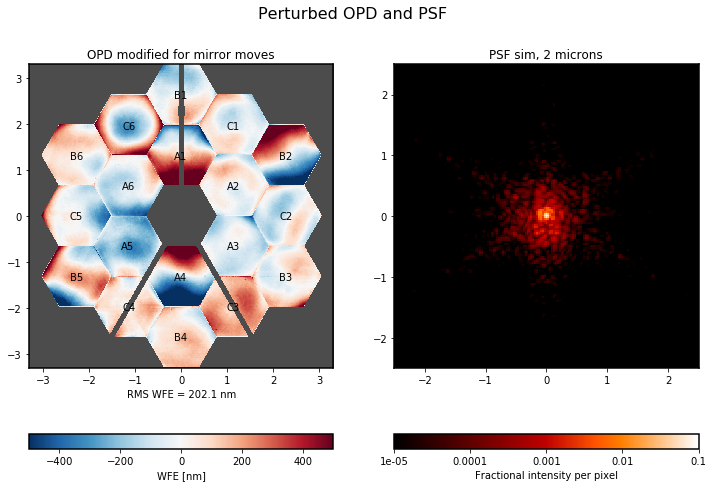

In [42]:
# Let's apply some medium perturbations. These are large enough to be easily seen, and would
# certainly be sensed and corrected for in flight. 
ote.reset()
ote.move_seg_local('A1', xtilt=.5)  # default units are microradians for tilts, microns for translations
ote.move_seg_local('B2', ytilt=.5)
ote.move_seg_local('C3', piston=100, trans_unit='nm')
ote.move_seg_local('A4', radial=10, trans_unit='micron')
ote.move_seg_local('B5', clocking=500 )
ote.move_seg_local('C6', roc=.5 )
display_ote_and_psf(nc, ote, title="Perturbed OPD and PSF")

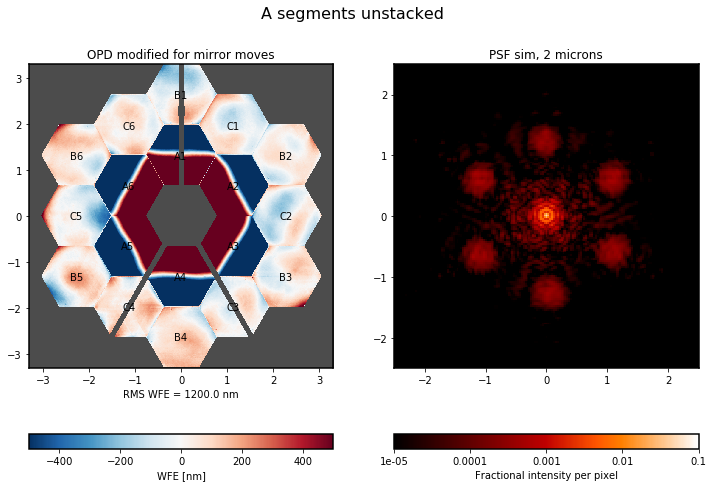

In [43]:
# We can also simulate very unstacked situations, such as will be seen during commissioning.
ote.reset()
for i in range(1,7):
    ote.move_seg_local('A'+str(i), xtilt=3)
display_ote_and_psf(nc, ote, title="A segments unstacked")

### Example Secondary Mirror moves

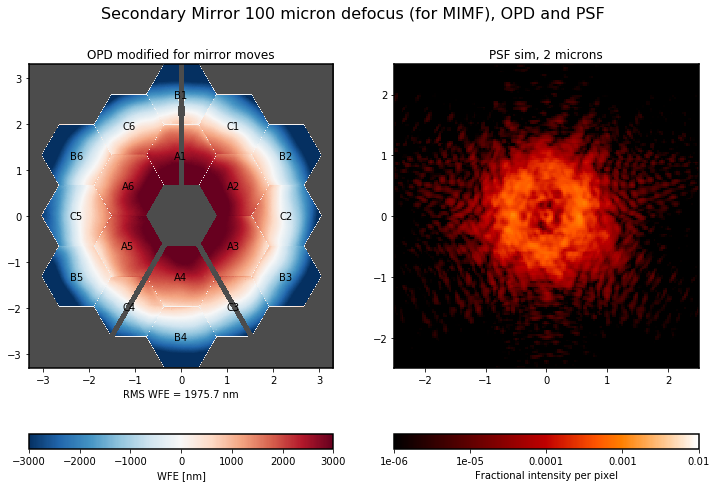

In [58]:
ote.reset()
ote.move_sm_local(piston=100)  
display_ote_and_psf(nc, ote, opd_vmax=3000, psf_vmax=0.01,
                    title="Secondary Mirror 100 micron defocus (for MIMF), OPD and PSF")

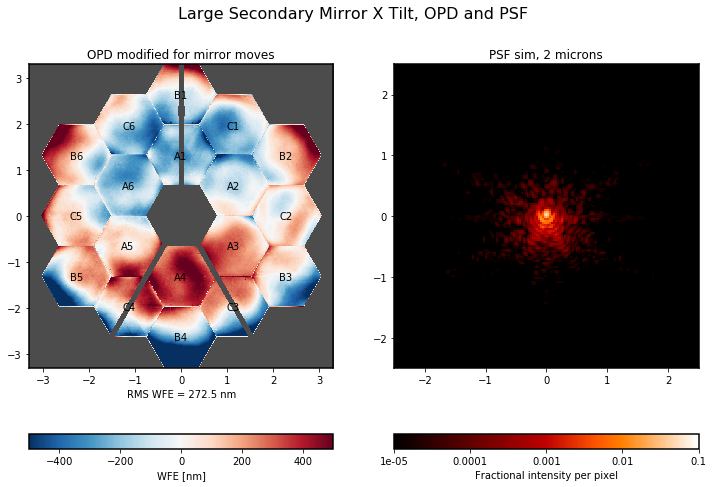

In [44]:
ote.reset()
ote.move_sm_local(xtilt=200)  
display_ote_and_psf(nc, ote, title="Large Secondary Mirror X Tilt, OPD and PSF")

## Segment Image Array configurations

There is a helper function for setting up the standard 'image array' configurations used during commissioning. You can use named sizes 'small', 'medium', and 'large', or directly specify a radius in arceconds. 

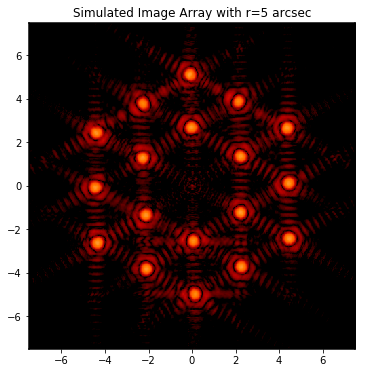

In [51]:
radius = 5
disp_kwargs = {'colorbar':False, 'ext':1, 'vmax':3e-3, 'vmin':3e-7}
ote.reset()
webbpsf.opds.setup_image_array(ote, radius=radius, reset=True, verbose=False)
psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_arcsec=15,)
plt.figure(figsize=(6,6))
webbpsf.display_psf(psf, **disp_kwargs)
plt.title("Simulated Image Array with r={} arcsec".format(radius))

### Small, Medium, Large arrays

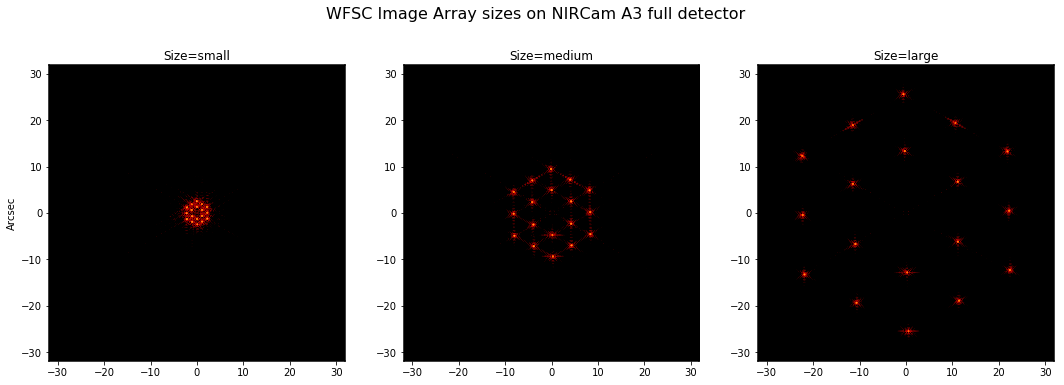

In [52]:
plt.figure(figsize=(18,6))
for i, size in enumerate(['small', 'medium', 'large']):
    webbpsf.opds.setup_image_array(ote, size=size, reset=True, verbose=False)
    psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048,)

    plt.subplot(1,3,i+1)
    webbpsf.display_psf(psf, **disp_kwargs)
    plt.title("Size={}".format(size))
    if i==0:
        plt.ylabel("Arcsec")
plt.suptitle("WFSC Image Array sizes on NIRCam A3 full detector", fontsize=16)

###  Coarse MIMF

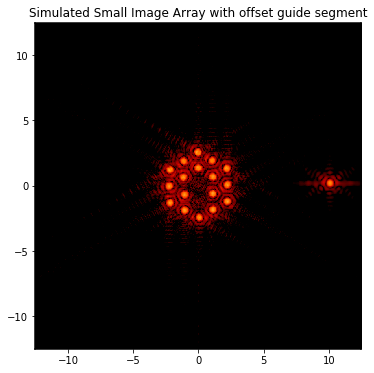

In [53]:
webbpsf.opds.setup_image_array(ote, size='small',guide_seg='A1', reset=True, verbose=False)
psf = nc.calc_psf(monochromatic=2e-6, oversample=1, fov_arcsec=25,)
plt.figure(figsize=(6,6))
webbpsf.display_psf(psf, **disp_kwargs)
plt.title("Simulated Small Image Array with offset guide segment")

##  Random Segment Unstacking and images for GPR 

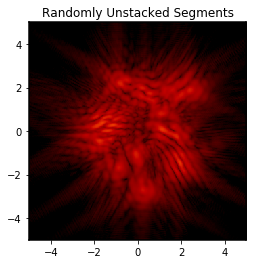

In [75]:
ote.reset()
webbpsf.opds.random_unstack(ote, radius=0.5)
psf = nc.calc_psf( oversample=1, fov_arcsec=10,)
webbpsf.display_psf(psf, colorbar=False, ext=1, title="Randomly Unstacked Segments")

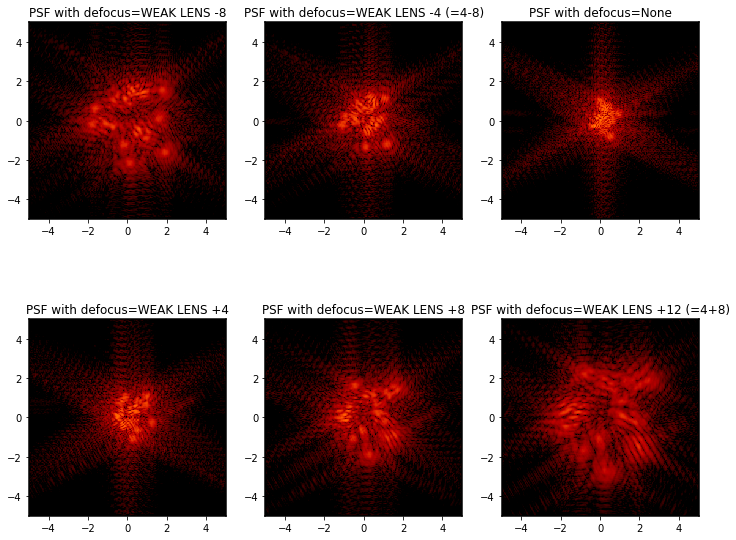

In [76]:
weaklens_set = [ 'WEAK LENS -8',
                 'WEAK LENS -4 (=4-8)',
                None,
                'WEAK LENS +4',
                'WEAK LENS +8',
                'WEAK LENS +12 (=4+8)']
psfs = []
for i,wl in enumerate(weaklens_set):
    nc.pupil_mask = wl
    psfs.append(nc.calc_psf(monochromatic=2e-6, oversample=1, fov_arcsec=10))    
plt.figure(figsize=(12,10))
for i,wl in enumerate(weaklens_set):
    ax=plt.subplot(2,3,i+1)
    webbpsf.display_psf(psfs[i], colorbar=False, ax=ax,
                        title='PSF with defocus={}'.format(weaklens_set[i]))

## Incoherent PSFs

Note, if you want to simulate incoherent segments (i.e. not yet coarse phased), then you need to perform broadband rather than monochromatic simulations to get even approximately the right answer. This is because polychromatic calculations are needed to capture the loss of coherence from pistons beyond the coherence length. 


For filtered blackbody radiation, you can calculate the coherence length as `c/(delta f)`   where `delta f` is the filter’s bandwidth in frequency units (i.e. the maximum frequency minus the minimum frequency).  For the FGS that works out to about 0.7 microns.   For a narrow filter like F212N,  the coherence length is a couple hundred microns. If the segments are more than that much out of phase, you need a broadband calculation, or else to calculate each segment individually and sum the resulting intensities (_not_ sum the complex wavefronts) 

(<matplotlib.axes._subplots.AxesSubplot at 0x1195bc588>,
 <matplotlib.colorbar.Colorbar at 0x116fc2d68>)

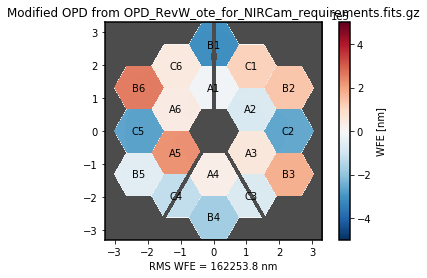

In [70]:
ote.reset()
random_pistons = np.random.randn(18)*100  # substantial coarse phasing erorrs. 
for i, seg in enumerate(ote.segnames[0:18]):  # don't piston "segment 19" the SM
    ote.move_seg_local(seg,piston=random_pistons[i])
ote.display_opd(vmax=500000)  # 500 microns

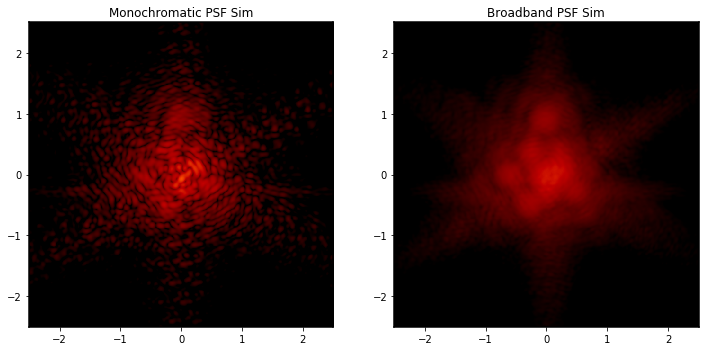

In [69]:
mono_psf = nc.calc_psf(monochromatic=2e-6)
bb_psf = nc.calc_psf(nlambda=30)
plt.figure(figsize=(12,7))
plt.subplot(121)
webbpsf.display_psf(mono_psf, title='Monochromatic PSF Sim', colorbar=False)
plt.subplot(122)
webbpsf.display_psf(bb_psf, title='Broadband PSF Sim', colorbar=False)

In this example we also see that the large piston moves come with small tilt cross terms that result in slightly unstacking the segments. We could take these out by adjusting the segment tip/tilts, but we didn't do that for this sim.

# JSC OTIS Test Configurations

WebbPSF now includes an option for the JSC pupil with the 3 ACFs.
However it doesn't yet have the gravity sag figure errors per each segment. 

(<matplotlib.axes._subplots.AxesSubplot at 0x116f56160>,
 <matplotlib.colorbar.Colorbar at 0x118fd10f0>)

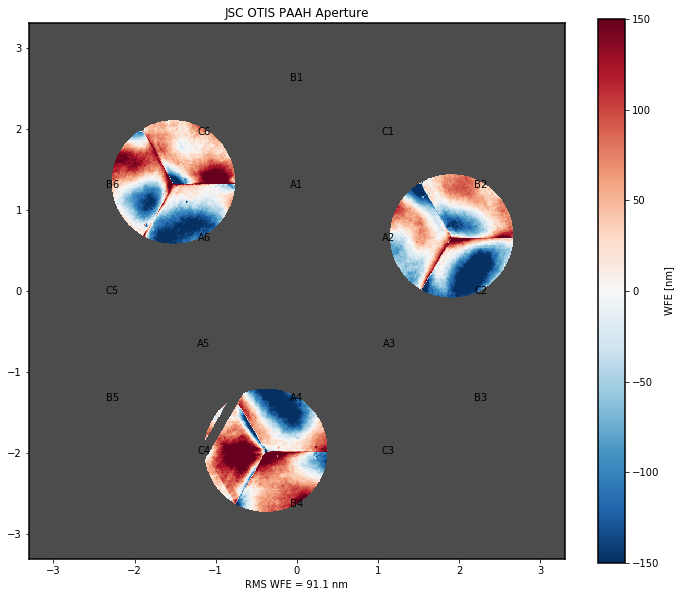

In [80]:
ncjsc, otis = webbpsf.opds.enable_adjustable_ote(webbpsf.NIRCam(), jsc=True)
plt.figure(figsize=(12,10))
otis.display_opd(title='JSC OTIS PAAH Aperture')

We can simulate the Hartman test array configuration used at JSC. 

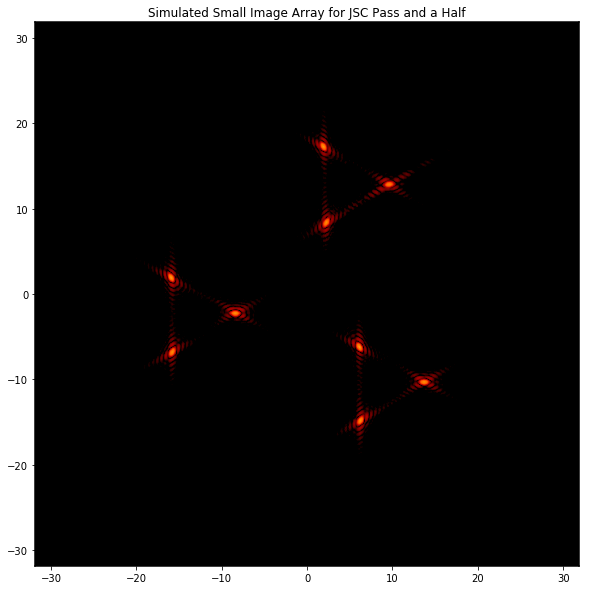

In [82]:
webbpsf.opds.setup_image_array(otis, reset=True, size='jsc')
psf_jsc = ncjsc.calc_psf(monochromatic=2e-6, oversample=1, fov_pixels=2048,)
plt.figure(figsize=(12,10))
webbpsf.display_psf(psf_jsc, **disp_kwargs)
plt.title("Simulated Small Image Array for JSC Pass and a Half")